# Tutorial #2: Cantera and User-Defined Functions

__Motivation:__

Now is the point in this course where we will introduce and use the Cantera software package to perform detailed
 kinetic simulations.
Some of you may have previously used Cantera in Thermodynamics to access thermodynamic data and view equilibrium
 chemistry.
Regardless of whether you have had previous exposure, here we're going to introduce you to the chemical-kinetic
 capabilities of Cantera and guide you through using them.

## 1. User-Defined Functions

Prior to launching into Cantera, we first take a moment to introduce user-defined functions.
Defining functions allows for modularizing and reusing code, which greatly simplifies the implementation of complex
 computational tasks.

The basic form for defining a function in Python is as follows:
```
def <function_name>(<args*>, <kwargs**>):
    code...
    ...
    ...
    return <return variable(s)>
```

In this form:
* `def` is the keyword that tells Python we are defining a function
* `<function_name>` is the name we will use to reference our new function
* `<args*>` is a list of required arguments (variables) that are:
  * required by the function
  * provided to the function in a pre-determined order
* `<kwargs*>` is a list of keyword arguments that are:
  * optional whether you provide them when running the function
  * specified with a default value that is used if no other value is provided
* `:` ends the function definition line
* whitespace: code within a function must be consistently padded by whitespace
  * Python interprets encountering non-tabbed code as having reached the end of the function
* `return` keyword passes the argument(s) listed after it back to the calling code
  * If more than one value is listed, the values are grouped and returned as a tuple

Let's look at some example function definitions, starting with the area of a triangle

In [1]:
def triangle_area(base, height):
    return 0.5 * base * height

triangle_area(3, 2)

3.0

That wasn't so hard!

While this example is pretty trivial, it let's us see how we might use it to implement more advanced functionality, like
 input validation.

In [2]:
def triangle_area(base, height):
    if base < 0 or height < 0:
        raise Exception('Base and height of a triangle must be non-negative')
    return 0.5 * base * height

print(triangle_area(3, 2))
# print(triangle_area(-3, 2))

3.0


We know that the dimensions of a triangle have to be positive, so we can check for that and `raise` a custom `Exception`
 message if a negative value is encountered.

To illustrate the use of keyword arguments, imagine we want to compute points along a line of the form `y = mx + b`,
 and let's assume that `b` is _usually_ zero.
We want to make our function generalizable (i.e. be _able_ to specify other values of `b`), but we don't want to have to
 enter `b` in all the cases where it is, in fact, zero.

In [3]:
def y(m, x, b=0):
    return m * x + b

print(y(2, 3))
print(y(0, 2))
print(y(0, 2, b=1.))

6
0
1.0


In the first two cases, we don't specify a value for `b`, and the default of zero is used.
In the final example, the value of `b` is overwritten by providing a keyword argument.

## 2. Cantera

We are finally here, ready to introduce Cantera for Python.
The material covered in this tutorial is not meant to be comprehensive, but should cover what you need to know to do the
 problem set.
We additionally hope this material will allow you to get you feet wet enough to be able to start making sense of the
 documentation, describing the full functionality of Cantera, which can be found here:
[Cantera Documentation](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/index.html)

For consistency, we always import Cantera using the name `ct`.
We will also go ahead and import some additional useful packages right away.

In [4]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

__a) Initialize a solution object__

For this example, we will use the "Stanford Mechanism v1.2".
This mechanism is not built-in to Cantera (the way 'GRI Mech 3.0' is), so we must get the file path to the mechanism
 '.cti' file stored elsewhere in the repository.

In [30]:
mech_file = os.path.abspath('../mechanisms/stanford-mech_v12.cti')
mech_file

'C:\\Users\\asusa\\pycharm_projects\\me362b_winter2021\\mechanisms\\stanford-mech_v12.cti'

We can now pass this filepath as an argument to the `ct.Solution` class to create an instance of the class based on this
 mechanism.

Placing empty parenthesis `()` after the Solution instance name produces an output of it's state.

In [6]:
gas = ct.Solution(mech_file)
gas()


  Stanford_v1.2:

       temperature             300  K
          pressure          101325  Pa
           density       0.0818891  kg/m^3
  mean mol. weight         2.01588  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy           26470        5.336e+04     J
   internal energy     -1.2109e+06       -2.441e+06     J
           entropy           64914        1.309e+05     J/K
    Gibbs function     -1.9448e+07        -3.92e+07     J
 heat capacity c_p           14312        2.885e+04     J/K
 heat capacity c_v           10187        2.054e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2              1                1         -15.7173
     [   +9 minor]              0                0



__b) Accessing and assigning state variables__

Properties, accessed with dot notation but without `()` or arguments, are used to access state properies of `gas`

In [7]:
print(f'T = {gas.T:3.1f} K')
print(f'P = {gas.P:3.0f} Pa')
print(f'rho = {gas.density_mass:5.4f} kg/m^3')
print(f'TPX = {gas.TPX}')

T = 300.0 K
P = 101325 Pa
rho = 0.0819 kg/m^3
TPX = (300.0, 101324.99999999999, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


We can also set properties through assignment.
We cannot assign temperature or pressure one at a time, as it would result in ambiguity as to what constraint to
 enforce (constant volume, constant enthalpy, constant entropy, etc.).
However, we can assign pairs of state variables, wherein we can maintain a value as constant.

In [8]:
gas.TP = 1200, gas.P
print(f'T = {gas.T:3.1f} K')
print(f'P = {gas.P:3.0f} Pa')

gas.TP = gas.T, 1e6
print(f'T = {gas.T:3.1f} K')
print(f'P = {gas.P:3.0f} Pa')

T = 1200.0 K
P = 101325 Pa
T = 1200.0 K
P = 1000000 Pa


__c) Setting and retrieving mole fractions__

During simulations, we will often want to monitor the mole fraction of a species or species.

If we use the `X` property to get the mole fractions...

In [9]:
gas.X

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We get an array of values, corresponding, in order, to the species in the mechanism:

In [10]:
gas.species_names

['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'N2', 'AR']

While this might work okay in some instances, it is a bit tedious to figure out which mole fraction corresponds to each
 species.
Not that we can't do it, e.g.

In [11]:
for sp, x in zip(gas.species_names, gas.X):
    print(f'{sp:5s}: {x}')

H2   : 1.0
H    : 0.0
O    : 0.0
O2   : 0.0
OH   : 0.0
H2O  : 0.0
HO2  : 0.0
H2O2 : 0.0
N2   : 0.0
AR   : 0.0


Depending what we are doing with it, it may be easier to have the mole fractions in a dictionary.
`mole_fraction_dict` takes an optional threshold argument (default 0), and only returns species with mole fractions
 above the threshold.
Setting the threshold negative returns all species.

In [12]:
gas.mole_fraction_dict()

{'H2': 1.0}

In [13]:
gas.mole_fraction_dict(-1)

{'AR': 0.0,
 'H': 0.0,
 'H2': 1.0,
 'H2O': 0.0,
 'H2O2': 0.0,
 'HO2': 0.0,
 'N2': 0.0,
 'O': 0.0,
 'O2': 0.0,
 'OH': 0.0}

It is almost always easier to set mole fractions using a dictionary instead of an array.
If mole fractions do not sum to one, they are normalized automatically.

In [14]:
xs = {'N2':.79, 'O2':.21, 'H2':.21/0.5}  # stoichiometric H2 in air
gas.X = xs

gas.mole_fraction_dict()

{'H2': 0.29577464788732394,
 'N2': 0.5563380281690141,
 'O2': 0.14788732394366197}

Alternatively, we can separately define fuel and oxidizer compositions and set the mole fractions by equivalence ratio:
This can save us work having to recalculate component mole fractions.

In [15]:
fuel = {'H2':1}
ox = {'AR':.95, 'O2':.05}
gas.set_equivalence_ratio(1, fuel, ox)

gas.mole_fraction_dict()

{'AR': 0.8636363636363636,
 'H2': 0.09090909090909091,
 'O2': 0.045454545454545456}

__d) Setting up reactor and network objects__

Now that we have a gas object, we can set up our reactor and network:

In [16]:
r1 = ct.ConstPressureReactor(gas)
rnet = ct.ReactorNet((r1,))  # r1 must be passed within a tuple to the reactor network

rnet.time

0.0

We see in the above that we now have a reactor at time zero.

If we step the reactor:

In [17]:
rnet.step()

print(f'Time: {rnet.time:6.5e} s')
gas.mole_fraction_dict()

Time: 7.58903e-13 s


{'AR': 0.8636363636363636,
 'H': 1.338890557965026e-16,
 'H2': 0.09090909090909077,
 'H2O': 1.2407951403873235e-29,
 'H2O2': 5.270756008515221e-26,
 'HO2': 1.3388843310892455e-16,
 'O': 7.98538746307445e-24,
 'O2': 0.045454545454545324,
 'OH': 7.632385731357235e-24}

Repeatedly run the cell above and observe how, at every step:
* the reactor time increases
* the mole fractions change

It is tedious (and pointless) to do this manually, so let's wrap the step function in a loop to step it forward until a
 certain time is reached.
We'll add a counter as well to see how many steps it takes.

In [18]:
t_stop = 1e-3  # 1 ms
count = 0

while rnet.time < t_stop:
    rnet.step()
    count += 1

print(f'{count} TIme Steps Taken')
print(f'Time: {rnet.time:6.5e} s')
gas.mole_fraction_dict()

1067 TIme Steps Taken
Time: 1.00174e-03 s


{'AR': 0.8956635259915019,
 'H': 0.004598904931980785,
 'H2': 0.009881817791547514,
 'H2O': 0.08002162650940889,
 'H2O2': 2.150172641881425e-07,
 'HO2': 4.4407077890027225e-07,
 'O': 0.0012554302287357236,
 'O2': 0.00442396078398726,
 'OH': 0.0041540746747949775}

__e) Saving simulation results__

We've now seen how to run a simulation, but we have not, so far, actually saved any of our simulation results! Oh no!

Let's reset our simulation and see what we can do to record its change through time.

We'll find we need to reset our simulations a lot between runs.
To save time, let's use a function to do this for us.

In the cell below, we first define some default parameters for our simulation.
Then, we define a function to reset the `Solution` object to the initial state, allowing our default parameters to be
 overwritten.
We'll also create a new reactor and network in the function, and return them.

In [19]:
T0 = 1200  # K
P0 = 101325  # Pa (1 atm)
phi = 1.
fuel = {'H2':1.}
oxidizer = {'AR':.79, 'O2':.21}  # "airgon"

def reset_simulation(sln, T=T0, P=P0, phi=phi, f=fuel, ox=oxidizer):
    sln.set_equivalence_ratio(phi=phi, fuel=f, oxidizer=ox)
    sln.TP = T, P
    r1 = ct.ConstPressureReactor(sln)
    rnet = ct.ReactorNet([r1])
    return r1, rnet

And that's it!
We don't have to return the solution object (but we could if we wanted).
When passed to a function, only a _reference_ to the `Solution` object is passed, not a copy of the object.
Therefore, anything done to the object within the function also affects the object outside the function.

__Note:__ This is an important subtlety of Python and can lead to unexpected behavior if not understood.
For the sake of this class, we have tried to structure things such that this behavior (hopefully) won't cause you
 trouble.

We do return the __Reactor__ and __ReactorNet__ objects, as those are newly created within the function.
Their _scope_ only extends until the function concludes, unless their references are returned.

Let's test it:

In [20]:
r1, rnet = reset_simulation(gas)
gas()


  Stanford_v1.2:

       temperature            1200  K
          pressure          101325  Pa
           density        0.279815  kg/m^3
  mean mol. weight         27.5531  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      8.2597e+05        2.276e+07     J
   internal energy      4.6386e+05        1.278e+07     J
           entropy          7187.4         1.98e+05     J/K
    Gibbs function     -7.7989e+06       -2.149e+08     J
 heat capacity c_p          943.83        2.601e+04     J/K
 heat capacity c_v          642.07        1.769e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2       0.295775        0.0216399         -19.1957
                O2       0.147887         0.171749         -28.9983
                AR       0.556338         0.806611         -20.7987
     [   +7 minor]

There we have it, we're back where we want to be, with unreacted fuel-air mixture.

If we look at the reactor network:

In [21]:
rnet.time

0.0

It's back at time zero, since we created a brand-new object. 
Before we start stepping our simulation again, let's figure out how to store our results.

A simple method is to store the results for each variable of interest in `list`.
Let's see what that might look like:

In [22]:
# We can define empty lists for each variable of interest
time = []
T = []
H2 = []
O2 = []
OH = []
H2O = []

In [23]:
# We can then run the simulation, appending items to the lists for each step
t_stop = 1e-3  # 1 ms

while rnet.time < t_stop:
    rnet.step()
    time += [rnet.time]
    T += [gas.T]
    xs = gas.mole_fraction_dict(-1)
    H2 += [xs['H2']]
    O2 += [xs['O2']]
    OH += [xs['OH']]
    H2O += [xs['H2O']]

We call the `mole_fraction_dict` method with the argument `-1` to make sure that all species in the mechanism have
 entries in the dictionary.
If we didn't do this, species with mole fractions of zero would not appear in the dictionary and would raise errors
 when accessed.

And now we can plot our results:

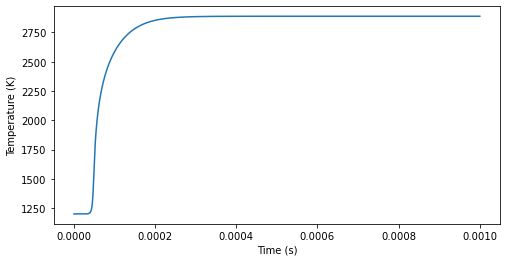

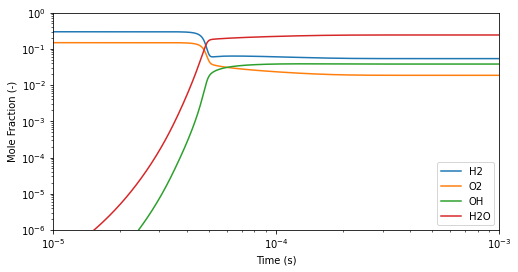

In [24]:
plt.figure(figsize=(8,4))
plt.plot(time, T)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

plt.figure(figsize=(8,4))
for sp, x in zip(['H2', 'O2', 'OH', 'H2O'], [H2, O2, OH, H2O]):
    plt.loglog(time, x, label=sp)
plt.xlabel('Time (s)')
plt.ylabel('Mole Fraction (-)')
plt.xlim((1e-5, 1e-3))
plt.ylim((1e-6, 1))
plt.legend()

And there we have it - our first kinetic simulation time-series data!

__An aside on measuring computational efficiency__

Another option getting mole fractions would be to call `mole_fraction_dict` with no argument and use the the `get`
 method to access dictionary keys, passing the second argument `0` as a default if the key is not found
 (i.e. species doesn't appear in the `mole_fraction_dict`).

Since getting mole fractions is something that will be done many times during simulations, we might want to make sure
 we're doing this as efficiently as possible.
We can set up cells with the different access methods, using the "cell magic" `&&timeit` in a cell to tell Jupyter to
 compute how long a cell takes to run.

In [25]:
%%timeit

# return all species in the dictionary, then access the dictionary through dictionary indexing
gas.mole_fraction_dict(-1)['H2']

3.01 µs ± 96.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
%%timeit

# return only species with non-zero mole fractions, then access the dictionary with the 'get' method
gas.mole_fraction_dict().get('H2', 0)

2.77 µs ± 51.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


We see the two methods take close to the same time to run.
Another option would be to access mole fractions from the mole-fraction array.

In [27]:
%%timeit

gas.X[gas.species_index('H2')]

2.46 µs ± 168 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This is better!
What's more, the species index doesn't change, so if we store the index to a variable at the start of the run, we can
 just reuse the variable instead of re-calling the `species_index` method repeatedly.

In [28]:
i_H2 = gas.species_index('H2')

In [29]:
%%timeit

gas.X[i_H2]

1.52 µs ± 67 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Less than half the time of our original method!?

That could add up - we'll take it!

__f) Storing results in a dictionary__

We've seen how we can use lists to track variables at each step of a simulation run.
However, even with the relatively few variables we tracked in the last run, we ended up with a lot of variables
 floating around for all those lists.

A cleaner way to organize results would be in a `dict`, with the names of the variables as the keys and `lists` as the
 stored values.

Since we'll want a new one of these dictionaries for every simulation run, we'll write a function to initialize one.

In [31]:
def new_result_dict(sln: ct.Solution, species_list=None):
    # if the species list is None, make entries for all the species in the Solution object
    if species_list is None:
        species_list = sln.species_names
    else:  # remove any species in the list not in the Solution to prevent errors
        species_list = list(species_list)  # make sure the species_list is of type list
        for sp in species_list:
            if sp not in sln.species_names:
                print(f"{sp} not in mechanism; removed from tracked species.")
                species_list.remove(sp)

    # start initializing the dictionary with basic properties - time, temperature (T), pressure (P)
    result_dict = {'time':[],
                   'T':[],
                   'P':[]}
    # now add entries for the species
    for sp in species_list:
        result_dict[sp] = []
    # finally, add entries with a list of the species and their indices
    result_dict['species'] = species_list
    result_dict['indices'] = [sln.species_index(sp) for sp in species_list]

    return result_dict